# Task 4: SDEdit with DDPM
### *EE 367, Stanford University*

In this task, you will implement SDEdit (Score-Distillation Editing) using a pre-trained
DDPM, as introduced by Meng et al. (2022). Unlike traditional image generation, SDEdit
starts from a partially noised version of an input image rather than pure noise,
enabling controlled image editing while preserving key features.

Your tasks:
- Understand the partial noising process specific to SDEdit
- Implement the modified sampling loop with some starting point for time
- Apply controlled reverse diffusion from the partially noised state
- Analyze the effect of the noise level parameter (default is time=500)
- Compare results with different input images or different editing tasks

*Note:* Some helper functions are provided for you. Focus on implementing
the marked sections.

Before you begin:
1. Download the folder `diffusion_project`
2. Upload the folder to your Google Drive
3. Change runtime type to "T4 GPU" (click the drop-down button in the top right corner of this page for "Additional connection options" then click "change runtime type", change to "T4 GPU" and save)

## Connect to your Google Drive to access `diffusion_project` and setup model environment

This section handles the necessary setup steps to run diffusion models in Google Colab:
1. Connects to Google Drive to access project files
2. Imports required libraries
3. Loads the pretrained diffusion model and supporting components

The model is pretrained on FFHQ-256 dataset.

In [29]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/diffusion_project/" # Replace with your path to the diffusion_project folder
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

# Import required packages
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from functools import partial

from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import get_named_beta_schedule
from util.img_utils import clear_color
from util.logger import get_logger
from util.img_utils import Blurkernel

from PIL import Image
import numpy as np
from tqdm.auto import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from util.setup_env import setup_diffusion_environment

# Initialize the diffusion environment
setup = setup_diffusion_environment()

# Extract components
model = setup['model']
device = setup['device']
logger = setup['logger']


2025-03-14 17:56:52,422 [DPS] >> Device set to cuda:0.
2025-03-14 17:56:52,422 [DPS] >> Device set to cuda:0.
INFO:DPS:Device set to cuda:0.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/diffusion_project


## Initialize DDPM parameters
Initialize the key parameters needed for the diffusion process. These parameters control how noise is added and removed during the diffusion steps.

In [30]:
num_timesteps = 1000 # Total number of noise steps
betas = get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=num_timesteps)

alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = (1.0 - alphas_cumprod) / np.sqrt(alphas_cumprod)

posterior_mean_coef1 = betas * np.sqrt(alphas_cumprod_prev) / (1.0-alphas_cumprod)
posterior_mean_coef2 = (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod)

posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)
posterior_log_variance_clipped = np.log(
    np.append(posterior_variance[1], posterior_variance[1:])
)

## Define helper functions

This section defines utility functions needed for the diffusion process. Make use of the helper functions in your implementation.

In [31]:
def extract_and_expand(array, time, target):
    """
    Extract values from an array at specified timesteps and expand to match target shape.

    Args:
        array: Source array containing coefficient values
        time: Timestep indices to extract
        target: Tensor whose shape we want to match

    Returns:
        Expanded tensor matching target shape with values from array at specified times
    """
    array = torch.from_numpy(array).to(target.device)[time].float()
    while array.ndim < target.ndim:
        array = array.unsqueeze(-1)
    return array.expand_as(target)

def get_variance(x, t):
    """
    Calculate the variance of the posterior distribution at timestep t.

    Args:
        x: Input tensor containing model's variance predictions
        t: Current timestep indices

    Returns:
        Log variance interpolated between min and max values based on model prediction
    """
    model_var_values = x
    min_log = posterior_log_variance_clipped
    max_log = np.log(betas)

    # Extract and expand variance bounds
    min_log = extract_and_expand(min_log, t, x)
    max_log = extract_and_expand(max_log, t, x)

    # Interpolate between min and max variance (model_var_values is in [-1, 1])
    frac = (model_var_values + 1.0) / 2.0
    model_log_variance = frac * max_log + (1-frac) * min_log
    return model_log_variance

def process_xstart(x):
    """
    Clamp predicted x_0 values to valid range.

    Args:
        x: Input tensor to be processed

    Returns:
        Tensor with values clamped to [-1, 1] range
    """
    x = x.clamp(-1, 1)
    return x

## Define one step of sampling (i.e. calculate $\hat{x_0}$ and $x_{t-1}$)

This section implements the core sampling functions for the reverse diffusion process.
It contains three main components:

1. Single-step denoising (`denoise`): Predicts x_0 from noisy x_t
2. Posterior mean calculation (`q_posterior_mean`): Computes q(x_{t-1} | x_t, x_0)
3. Sampling step (`p_sample`): Performs one complete step of the reverse diffusion

These functions work together to gradually transform random noise into meaningful images. The functions are the same as the ones in previous tasks, so you can copy and paste the functions you implemented before.

In [32]:
def denoise(x_t, t, eps):
    """
    Perform single-step denoising using the predicted noise.
    i.e. x_0_hat from the DPS paper

    Args:
        x_t: Noisy image at timestep t
        t: Current timestep
        eps: Predicted noise from the model

    Returns:
        Denoised image prediction using the diffusion model equation
    """

    score = - eps / np.sqrt(1.0 - alphas_cumprod[t])

    ############### begin: complete the following code section  ###############
    x_0_hat = 1 / np.sqrt(alphas_cumprod[t]) * (x_t + (1 - alphas_cumprod[t]) * score)
    return process_xstart(x_0_hat)

    ############### end: complete the following code section  ###############

def q_posterior_mean(x_start, x_t, t):
    """
    Compute the mean of the diffusion posterior: q(x_{t-1} | x_t, x_0)

    Args:
        x_start: Predicted clean image (x_0)
        x_t: Current noisy image
        t: Current timestep

    Returns:
        Mean of the posterior distribution
    """
    assert x_start.shape == x_t.shape

    ############### begin: complete the following code section  ###############
    mean = posterior_mean_coef1[t] * x_start + posterior_mean_coef2[t] * x_t
    return mean

    ############### end: complete the following code section  ###############

def p_sample(model, x, t):
    """
    Perform one complete step of the sampling process.

    Args:
        model: The DDPM model
        x: Current noisy image
        t: Current timestep

    Returns:
        Dictionary containing:
        - sample: Next image in sequence (x_{t-1})
        - pred_xstart: Predicted clean image (x_0)
    """
    model_output = model(x, t)

    # Split into noise and variance predictions
    model_output, model_var_values = torch.split(model_output, x.shape[1], dim=1)

    # Predict x_0 and prepare for next step
    x_0_hat = process_xstart(denoise(x, t, model_output))
    x_t = q_posterior_mean(x_0_hat, x, t)

    # Add sampling noise scaled by predicted variance (except at t=0)
    noise = torch.randn_like(x)
    model_log_variance = get_variance(model_var_values, t)

    if t != 0:  # no noise when t == 0
        x_t += torch.exp(0.5 * model_log_variance) * noise

    return {'sample': x_t, 'pred_xstart': x_0_hat}

## Prepare measurement process

This section defines the forward measurement process:
1. Incorporate measurement noise
2. Mask generation for inpainting (box or random)
3. Forward operations for different editing tasks (inpainting or deconvolution)

In [33]:
sigma = 0.05 # Define noise parameter for measurement
def noiser(data):
    """
    Add Gaussian noise to input data for measurement robustness.

    Args:
        data: Input tensor to be noised

    Returns:
        Noised tensor with added Gaussian noise (sigma)
    """
    return data + torch.randn_like(data, device=data.device) * sigma

def mask_gen(data, mask_type):
    """
    Generate masks for image inpainting tasks.

    Args:
        data: Input image tensor of shape [1, 3, 256, 256]
        mask_type: Type of mask ('box' or 'random')

    Returns:
        Binary mask tensor where 0 indicates masked regions

    Supports:
    - 'box': Creates a 50x50 rectangular mask
    - 'random': Randomly masks 50% of pixels
    """
    mask = torch.ones_like(data) # torch.Size([1, 3, 256, 256])
    if mask_type=='box':
        box_x, box_y, box_w, box_h = 150, 100, 50, 50  # Define box coordinates and size
        mask[:, :, box_y:box_y+box_h, box_x:box_x+box_w] = 0.
    elif mask_type=='random':
        percentage_to_mask = 0.5  # Mask 50% of the image
        total_pixels = data.size(2) * data.size(3)
        num_pixels_to_mask = int(percentage_to_mask * total_pixels)
        mask_indices = np.random.choice(total_pixels, size=num_pixels_to_mask, replace=False)
        mask[:, :, mask_indices // data.size(3), mask_indices % data.size(3)] = 0
    return mask

def forward(data, task, mask_type):
    """
    Apply forward measurement operation based on specified task.

    Args:
        data: Input image tensor
        task: Type of editing task ('inpaint' or 'deconv')
        mask_type: Type of mask for inpainting

    Returns:
        Processed image according to task:
        - Inpainting: Masked image
        - Deconvolution: Blurred image

    Note: For deconvolution, uses Gaussian blur with kernel_size=61, std=3.0
    """
    if task=='inpaint':
      mask = mask_gen(data, mask_type)
      return data * mask.to(device)

    elif task=='deconv':
      conv = Blurkernel(blur_type='gaussian',
                        kernel_size=61,
                        std=3.0,
                        device=device).to(device)
      return conv(data)

## Implement sampling loop for SDEdit

This section implements the specialized sampling loop for SDEdit (Meng et al., 2022).
Unlike standard DDPM sampling, SDEdit starts from a partially noised version of
the input image at an intermediate timestep (time=500), enabling controlled editing
while preserving key image features. It also includes optional progress visualization.

In [48]:
def sdedit(model, x_start, measurement, record, save_root):

    # Note: initialization is different for sdedit compared to other methods

    ############### begin: complete the following code section  ###############
    starting_timestep = 800  # SDEdit starts from an intermediate noise level
    noise = torch.randn_like(measurement)  # Sample Gaussian noise
    img = np.sqrt(alphas_cumprod[starting_timestep]) * measurement + (np.sqrt(1 - alphas_cumprod[starting_timestep])) * noise

    # pbar = tqdm(list(range(starting_timestep, num_timesteps))[::-1])
    pbar = tqdm(list(range(starting_timestep))[::-1])

    ############### end: complete the following code section  ###############

    device = x_start.device

    for idx in pbar:
        time = torch.tensor([idx] * img.shape[0], device=device)

        img = img.requires_grad_()

        ############### begin: complete the following code section  ###############
        img = p_sample(model, img, time)['sample']

        ############### end: complete the following code section  ###############

        img = img.detach_()

        if record:
            if idx % 10 == 0:
                file_path = os.path.join(save_root, f"progress/x_{str(idx).zfill(4)}.png")
                plt.imsave(file_path, clear_color(img))

    return img

## Inference

This section demonstrates the complete SDEdit pipeline, from loading an input image
through measurement simulation to final edited result generation.

Choose appropriate settings for each option below by clicking the drop-down menu. Note that when you want to test for deconv, setting for mask_type does not matter.

In [49]:
# Load and preprocess test image
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
out_path = "results/"
fname = 'red_panda.jpg'
img = Image.open('data/samples/red_panda.jpg').convert('RGB') # Replace with your choice of test image
img = transform(img)

# Do inference
logger.info(f"Inference for image")
ref_img = img.to(device).unsqueeze(dim=0)

# Choose task and method
task = 'inpaint' #@param ["inpaint", "deconv"] {"type": "string"}
mask_type = 'box' #@param ["box", "random"] {"type": "string"}

# Forward measurement model (Ax + n)
y = forward(ref_img, task, mask_type)
y_n = noiser(y)

# Sampling
x_start = torch.randn(ref_img.shape, device=device).requires_grad_()
sample = sdedit(model, x_start, measurement=y_n, record=False, save_root=out_path)

2025-03-14 18:06:17,077 [DPS] >> Inference for image
2025-03-14 18:06:17,077 [DPS] >> Inference for image
INFO:DPS:Inference for image


  0%|          | 0/800 [00:00<?, ?it/s]

## Show results

Visualize the input, ground truth, and result images.

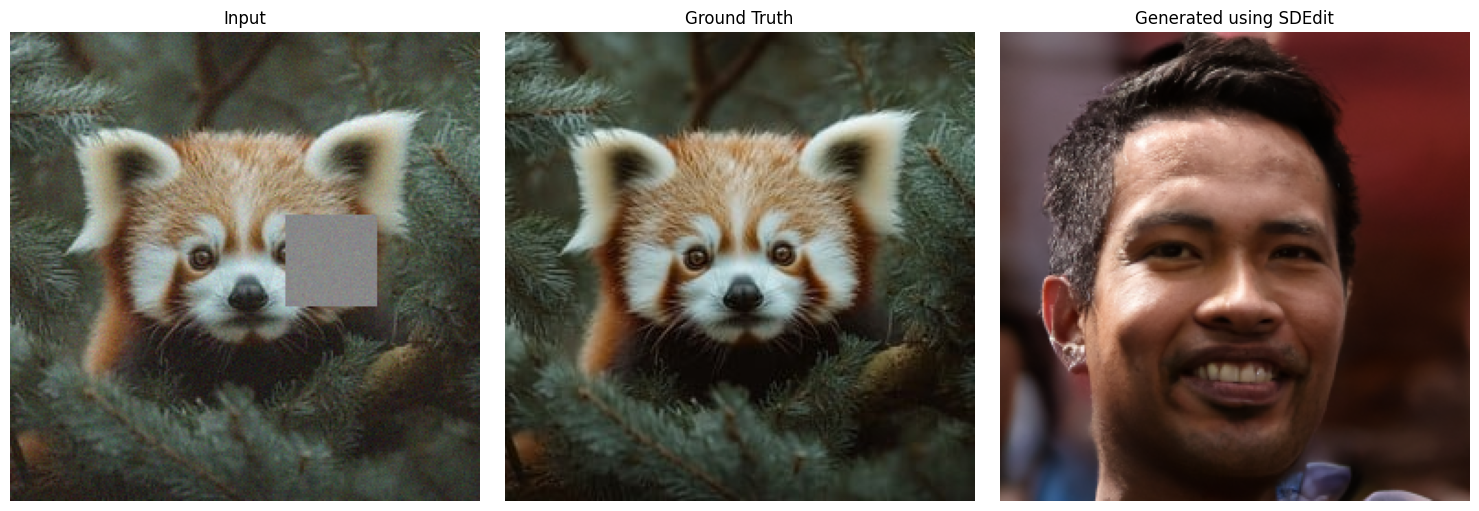

In [50]:
plt.imsave(out_path + f'input_{task}_sdedit_{fname}', clear_color(y_n))
plt.imsave(out_path + f'label_{task}_sdedit_{fname}', clear_color(ref_img))
plt.imsave(out_path + f'recon_{task}_sdedit_{fname}', clear_color(sample))

images = [clear_color(y_n), clear_color(ref_img), clear_color(sample)]
titles = ["Input", "Ground Truth", "Generated using SDEdit"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Evaluate the result

This section calculates standard image quality metrics to evaluate SDEdit performance:
1. PSNR (Peak Signal-to-Noise Ratio): Measures noise level/reconstruction quality (higher the better)
  *   *your result should be approx. 20 at time=500*
2. LPIPS (Learned Perceptual Image Patch Similarity): Measures perceptual similarity (lower the better)
  *   *your result should be approx. 0.19 at time=500*


In [51]:
import lpips
ref_img_np = ref_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
sample_np = sample.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Calculate PSNR & LPIPS
psnr_value = psnr(ref_img_np, sample_np, data_range=ref_img_np.max() - ref_img_np.min())
loss_fn = lpips.LPIPS(net='alex').to(device)
lpips_value = loss_fn.forward(ref_img, sample)

print("PSNR:", psnr_value)
print("LPIPS:", lpips_value.item())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
PSNR: 12.945529538549893
LPIPS: 0.7569090127944946
